In [1]:
import sklearn
from pathlib import Path

IMAGES_PATH = Path() / "output" / "08_dimensionality_reduction/extra_examples"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    print("Saving figure", fig_id)

Saving figure SwissRoll_PCA_Manifold_methods


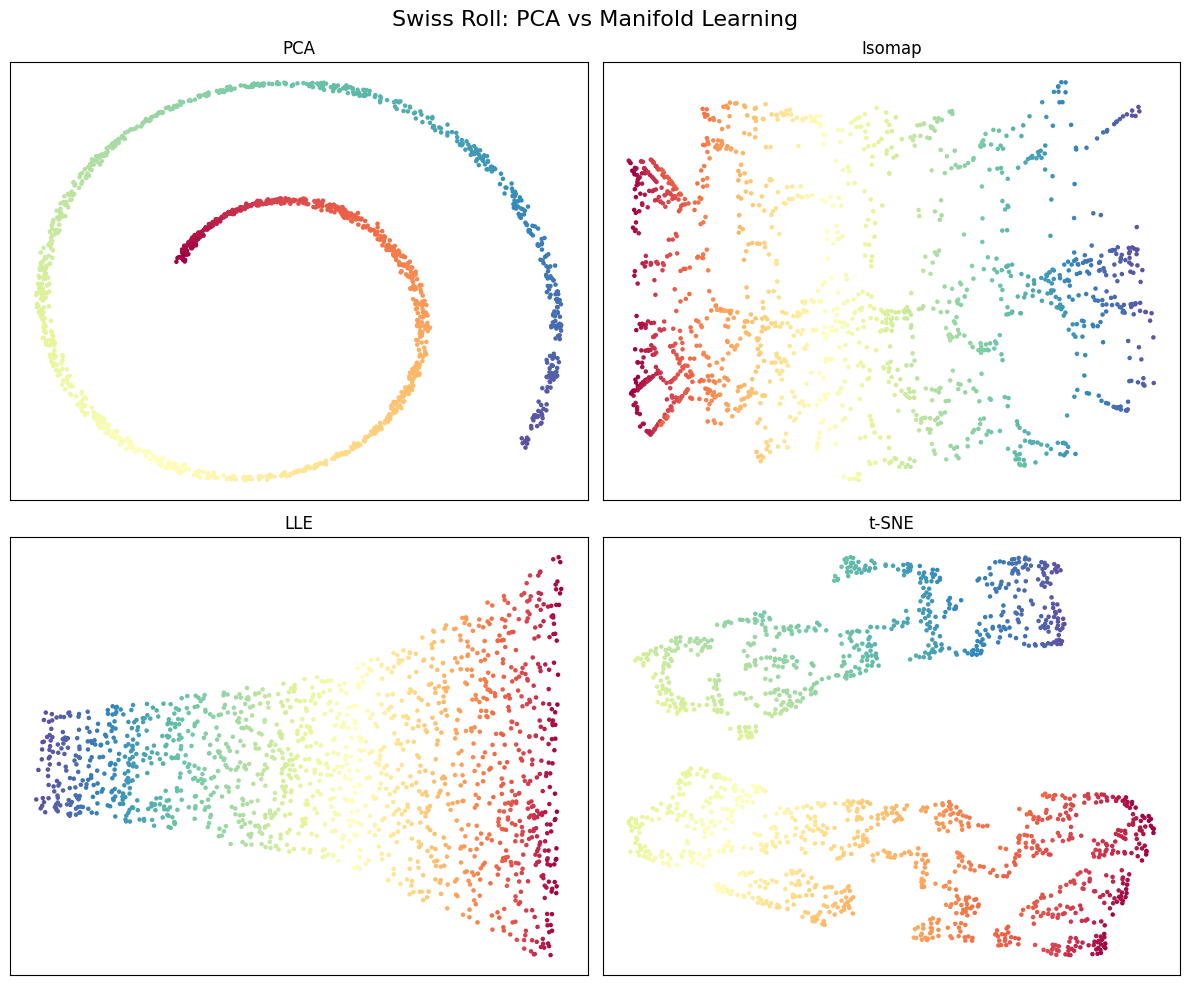

In [2]:
# Swiss Roll — PCA vs Manifold Learning (Isomap, LLE, t‑SNE)
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE

# Generate Swiss roll
X, color = make_swiss_roll(n_samples=1500, noise=0.05, random_state=42)

# Methods
pca = PCA(n_components=2)
isomap = Isomap(n_components=2)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=12, method='standard')
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42)

X_pca = pca.fit_transform(X)
X_isomap = isomap.fit_transform(X)
X_lle = lle.fit_transform(X)
X_tsne = tsne.fit_transform(X)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
methods = [
    ("PCA", X_pca),
    ("Isomap", X_isomap),
    ("LLE", X_lle),
    ("t-SNE", X_tsne)
]

for ax, (title, X_embedded) in zip(axes.ravel(), methods):
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color, cmap=plt.cm.Spectral, s=5)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Swiss Roll: PCA vs Manifold Learning", fontsize=16)
plt.tight_layout()
save_fig("SwissRoll_PCA_Manifold_methods")
plt.show()

Saving figure 3D_GaussianCloud_w_PCA_Axes


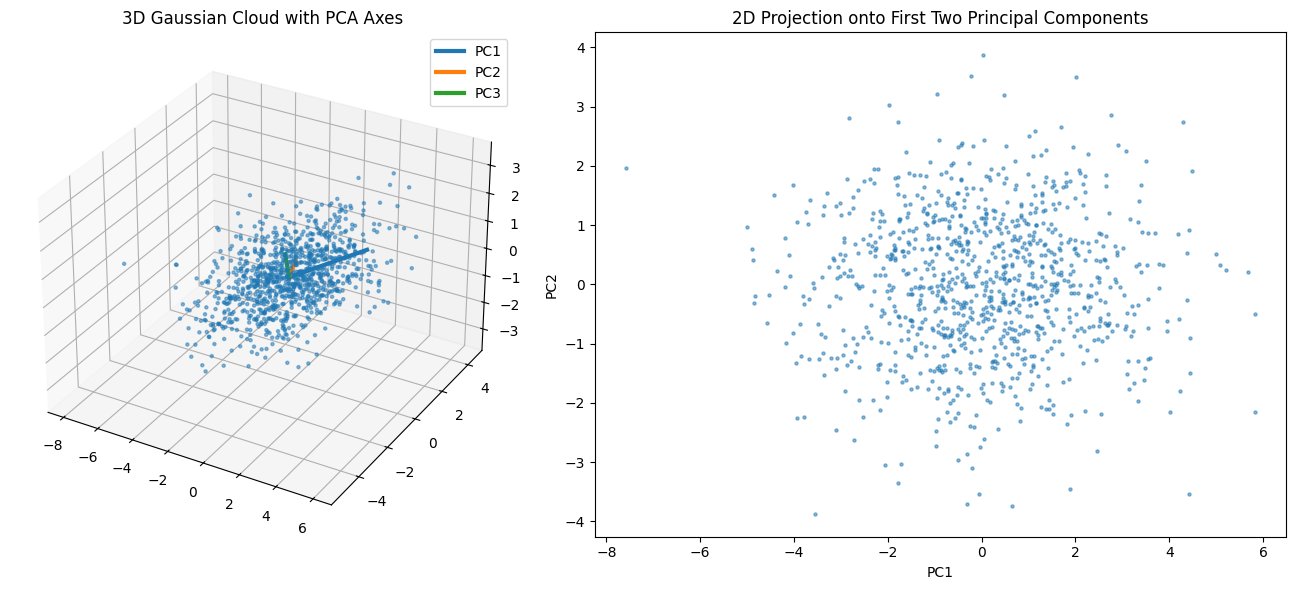

In [3]:
# PCA Projection of a 3D Gaussian Cloud
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Generate a 3D Gaussian cloud
np.random.seed(42)
mean = [0, 0, 0]
cov = [[3, 1, 0.5],
       [1, 2, 0.3],
       [0.5, 0.3, 1]]

X = np.random.multivariate_normal(mean, cov, size=1000)

# Fit PCA
pca = PCA(n_components=3)
pca.fit(X)
X_pca = pca.transform(X)

# Principal axes in original space
origin = pca.mean_
components = pca.components_
explained = pca.explained_variance_

# Scale axes for visualization
axes_scaled = components * explained[:, np.newaxis]

# Plotting
fig = plt.figure(figsize=(14, 6))

# --- 3D scatter with PCA axes ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], s=5, alpha=0.5)

# Draw PCA axes
for i in range(3):
    ax1.plot(
        [origin[0], origin[0] + axes_scaled[i, 0]],
        [origin[1], origin[1] + axes_scaled[i, 1]],
        [origin[2], origin[2] + axes_scaled[i, 2]],
        linewidth=3,
        label=f"PC{i+1}"
    )

ax1.set_title("3D Gaussian Cloud with PCA Axes")
ax1.legend()

# --- 2D PCA projection ---
ax2 = fig.add_subplot(1, 2, 2)
ax2.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.5)
ax2.set_title("2D Projection onto First Two Principal Components")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.tight_layout()
save_fig("3D_GaussianCloud_w_PCA_Axes")
plt.show()


In [4]:
# silence all the warnings since we don't have GPU and CUDA driver
import os
import warnings
from scipy.sparse import SparseEfficiencyWarning

# Silence TensorFlow INFO/WARNING messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Silence UMAP warnings
warnings.filterwarnings("ignore", category=UserWarning, module="umap")

# Silence Isomap warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.manifold")

# Silence SciPy sparse efficiency warnings
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

Saving figure Dimensionality_reduction_comparison


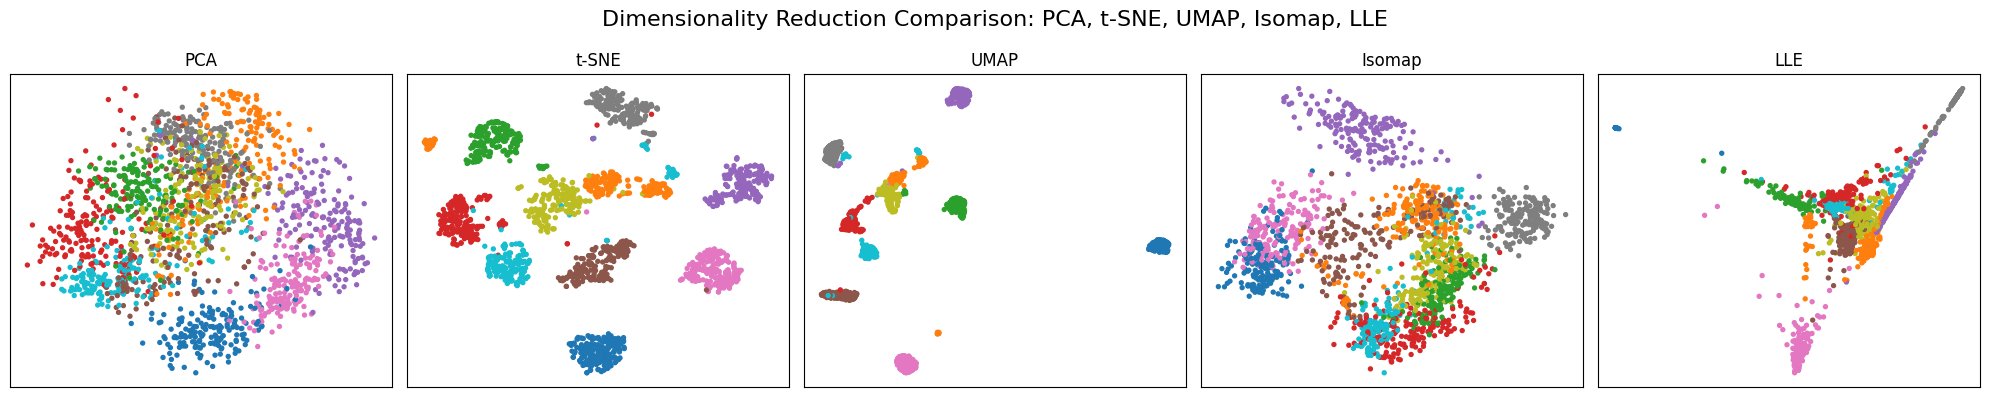

In [5]:
# Comparison Grid for different methods
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from umap import UMAP

# Load dataset
digits = load_digits()
X = digits.data
y = digits.target

# Dimensionality reduction methods
methods = [
    ("PCA", PCA(n_components=2)),
    ("t-SNE", TSNE(n_components=2, learning_rate='auto', init='pca', random_state=42)),
    ("UMAP", UMAP(n_components=2)),  # remove random_state for speed
    ("Isomap", Isomap(n_components=2, n_neighbors=15)),  # fix graph connectivity
    ("LLE", LocallyLinearEmbedding(n_components=2, n_neighbors=12, method='standard'))
]
# Fit and transform
embeddings = []
for name, model in methods:
    X_embedded = model.fit_transform(X)
    embeddings.append((name, X_embedded))

# Plot
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, (name, X_embedded) in zip(axes, embeddings):
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=plt.cm.tab10, s=8)
    ax.set_title(name)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Dimensionality Reduction Comparison: PCA, t-SNE, UMAP, Isomap, LLE", fontsize=16)
plt.tight_layout()
save_fig("Dimensionality_reduction_comparison")
plt.show()

In [6]:
# a reusable dimensionality reduction benchmark function
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from umap import UMAP

def benchmark_dimensionality_reduction(
    X,
    y=None,
    methods=None,
    figsize=(18, 4),
    point_size=8,
    random_state=42
):
    """
    Benchmark multiple dimensionality-reduction methods on the same dataset.

    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Input data.
    y : array-like, optional
        Labels for coloring the scatter plots.
    methods : list of (name, model) tuples
        Dimensionality-reduction methods to evaluate.
    figsize : tuple
        Figure size for the comparison plot.
    point_size : int
        Size of scatter plot points.
    random_state : int
        Random seed for reproducible methods.

    Returns
    -------
    results : dict
        Dictionary mapping method name → {
            "embedding": 2D array,
            "time": float (seconds)
        }
    """

    # Default methods if none provided
    if methods is None:
        methods = [
            ("PCA", PCA(n_components=2)),
            ("t-SNE", TSNE(n_components=2, learning_rate='auto', init='pca', random_state=random_state)),
            ("UMAP", UMAP(n_components=2, random_state=random_state)),
            ("Isomap", Isomap(n_components=2, n_neighbors=15)),
            ("LLE", LocallyLinearEmbedding(n_components=2, n_neighbors=12, method='standard'))
        ]

    results = {}

    # Fit + transform each method
    for name, model in methods:
        start = time.time()
        embedding = model.fit_transform(X)
        elapsed = time.time() - start

        results[name] = {
            "embedding": embedding,
            "time": elapsed
        }

    # Plot results
    fig, axes = plt.subplots(1, len(methods), figsize=figsize)

    for ax, (name, result) in zip(axes, results.items()):
        emb = result["embedding"]
        sc = ax.scatter(
            emb[:, 0], emb[:, 1],
            c=y if y is not None else "gray",
            cmap=plt.cm.tab10,
            s=point_size
        )
        ax.set_title(f"{name}\n{result['time']:.2f}s")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle("Dimensionality Reduction Benchmark", fontsize=16)
    plt.tight_layout()
    save_fig("Dimensionality_Reduction_Benchmark")
    plt.show()

    return results

Saving figure Dimensionality_Reduction_Benchmark


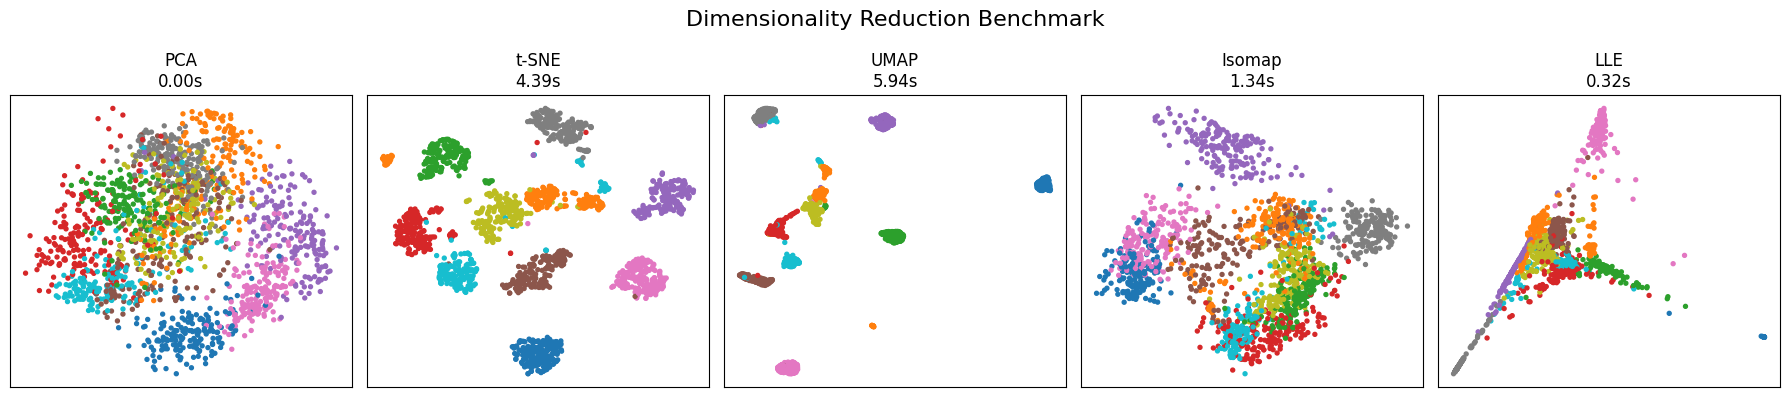

In [7]:
# 	This produces:
#		• a clean comparison plot
#		• timing for each method
# embeddings stored in results
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target

results = benchmark_dimensionality_reduction(X, y)

In [8]:
# Incremental PCA sample from ChapGPT
# n_components: number of principal components
# batch_size: trade-off between accuracy and memory
from sklearn.decomposition import IncrementalPCA
import numpy as np

X = np.random.randn(10000, 50)   # example data

batch_size = 256
ipca = IncrementalPCA(n_components=10, batch_size=batch_size)

for i in range(0, X.shape[0], batch_size):
    batch = X[i:i + batch_size]
    ipca.partial_fit(batch)

X_reduced = ipca.transform(X)

In [9]:
len(X), len(X_reduced)

(10000, 10000)

In [10]:
X.shape, X_reduced.shape

((10000, 50), (10000, 10))

In [11]:
# minimum example
import numpy as np
from sklearn.decomposition import IncrementalPCA

X = np.random.randn(1000, 20)

ipca = IncrementalPCA(n_components=5, batch_size=100)

for i in range(0, X.shape[0], 100):
    ipca.partial_fit(X[i:i+100])

X_reduced = ipca.transform(X)
print(X_reduced.shape)


(1000, 5)


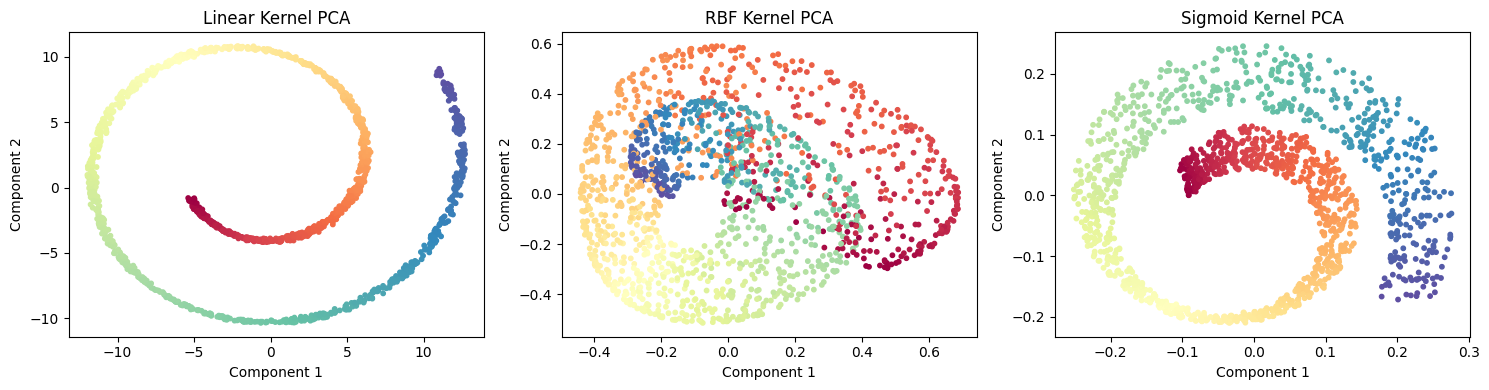

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

# ---------------------------------------------------------
# 1. Generate Swiss Roll
# ---------------------------------------------------------
X, t = make_swiss_roll(n_samples=1500, noise=0.05, random_state=42)

# ---------------------------------------------------------
# 2. Helper function to run Kernel PCA
# ---------------------------------------------------------
def run_kpca(kernel, **kwargs):
    kpca = KernelPCA(
        n_components=2,
        kernel=kernel,
        **kwargs,
        fit_inverse_transform=False,
        random_state=42
    )
    return kpca.fit_transform(X)

# ---------------------------------------------------------
# 3. Compute embeddings
# ---------------------------------------------------------
X_lin = run_kpca("linear")
X_rbf = run_kpca("rbf", gamma=0.02)
X_sig = run_kpca("sigmoid", gamma=0.001, coef0=1)

# ---------------------------------------------------------
# 4. Plotting function
# ---------------------------------------------------------
def plot_embedding(Z, title):
    plt.scatter(Z[:, 0], Z[:, 1], c=t, cmap=plt.cm.Spectral, s=10)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plot_embedding(X_lin, "Linear Kernel PCA")

plt.subplot(1, 3, 2)
plot_embedding(X_rbf, "RBF Kernel PCA")

plt.subplot(1, 3, 3)
plot_embedding(X_sig, "Sigmoid Kernel PCA")

plt.tight_layout()
plt.show()

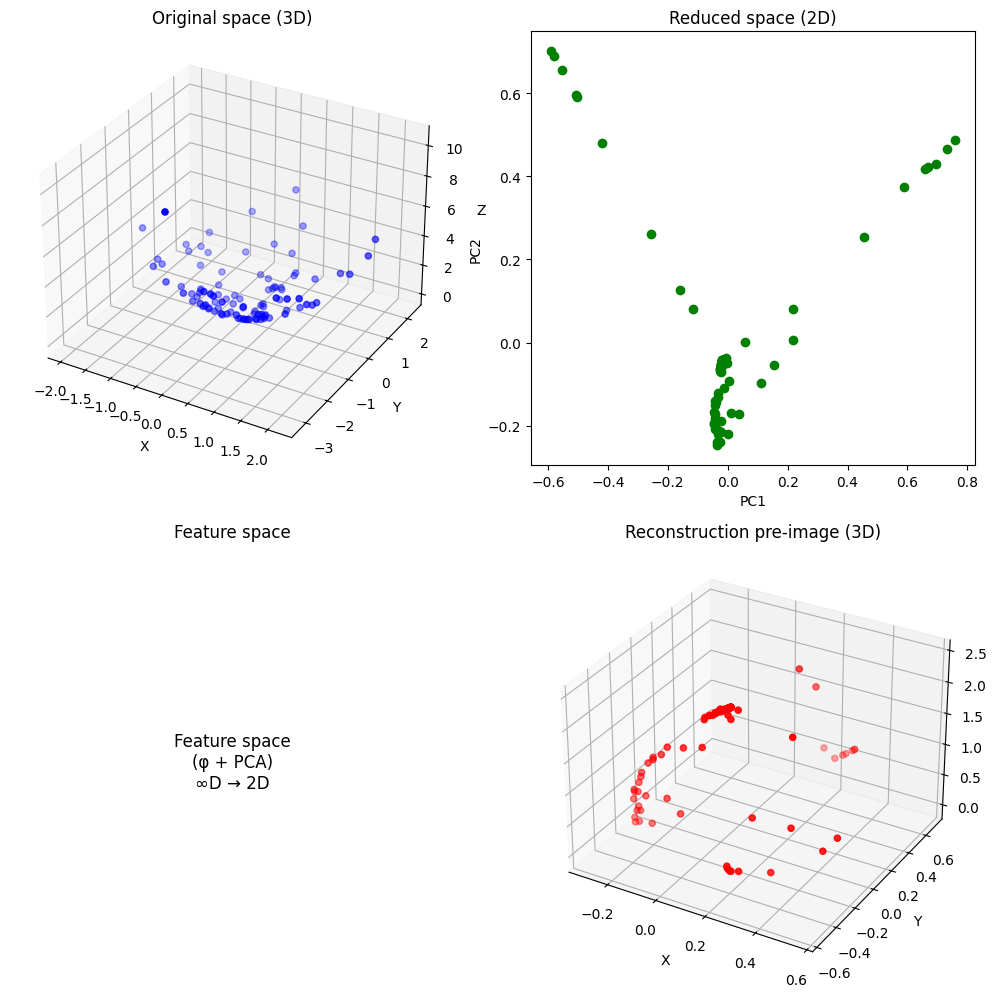

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D

# Generate synthetic 3D data
np.random.seed(42)
X = np.random.randn(100, 3)
X[:, 2] = X[:, 0]**2 + X[:, 1]**2  # Add nonlinearity

# Apply Kernel PCA
kpca = KernelPCA(n_components=2, kernel='rbf', fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(X)
X_reconstructed = kpca.inverse_transform(X_kpca)

# Plotting
fig = plt.figure(figsize=(10, 10))

# Original space (3D)
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', label='Original')
ax1.set_title('Original space (3D)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# Reduced space (2D)
ax2 = fig.add_subplot(222)
ax2.scatter(X_kpca[:, 0], X_kpca[:, 1], c='green', label='Reduced')
ax2.set_title('Reduced space (2D)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')

# Feature space (conceptual)
ax3 = fig.add_subplot(223)
ax3.text(0.5, 0.5, 'Feature space\n(φ + PCA)\n∞D → 2D', ha='center', va='center', fontsize=12)
ax3.set_title('Feature space')
ax3.axis('off')

# Reconstruction pre-image (3D)
ax4 = fig.add_subplot(224, projection='3d')
ax4.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], X_reconstructed[:, 2], c='red', label='Reconstructed')
ax4.set_title('Reconstruction pre-image (3D)')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')

plt.tight_layout()
plt.show()

Saving figure KernelPCA_and_reconstruction_pre_image


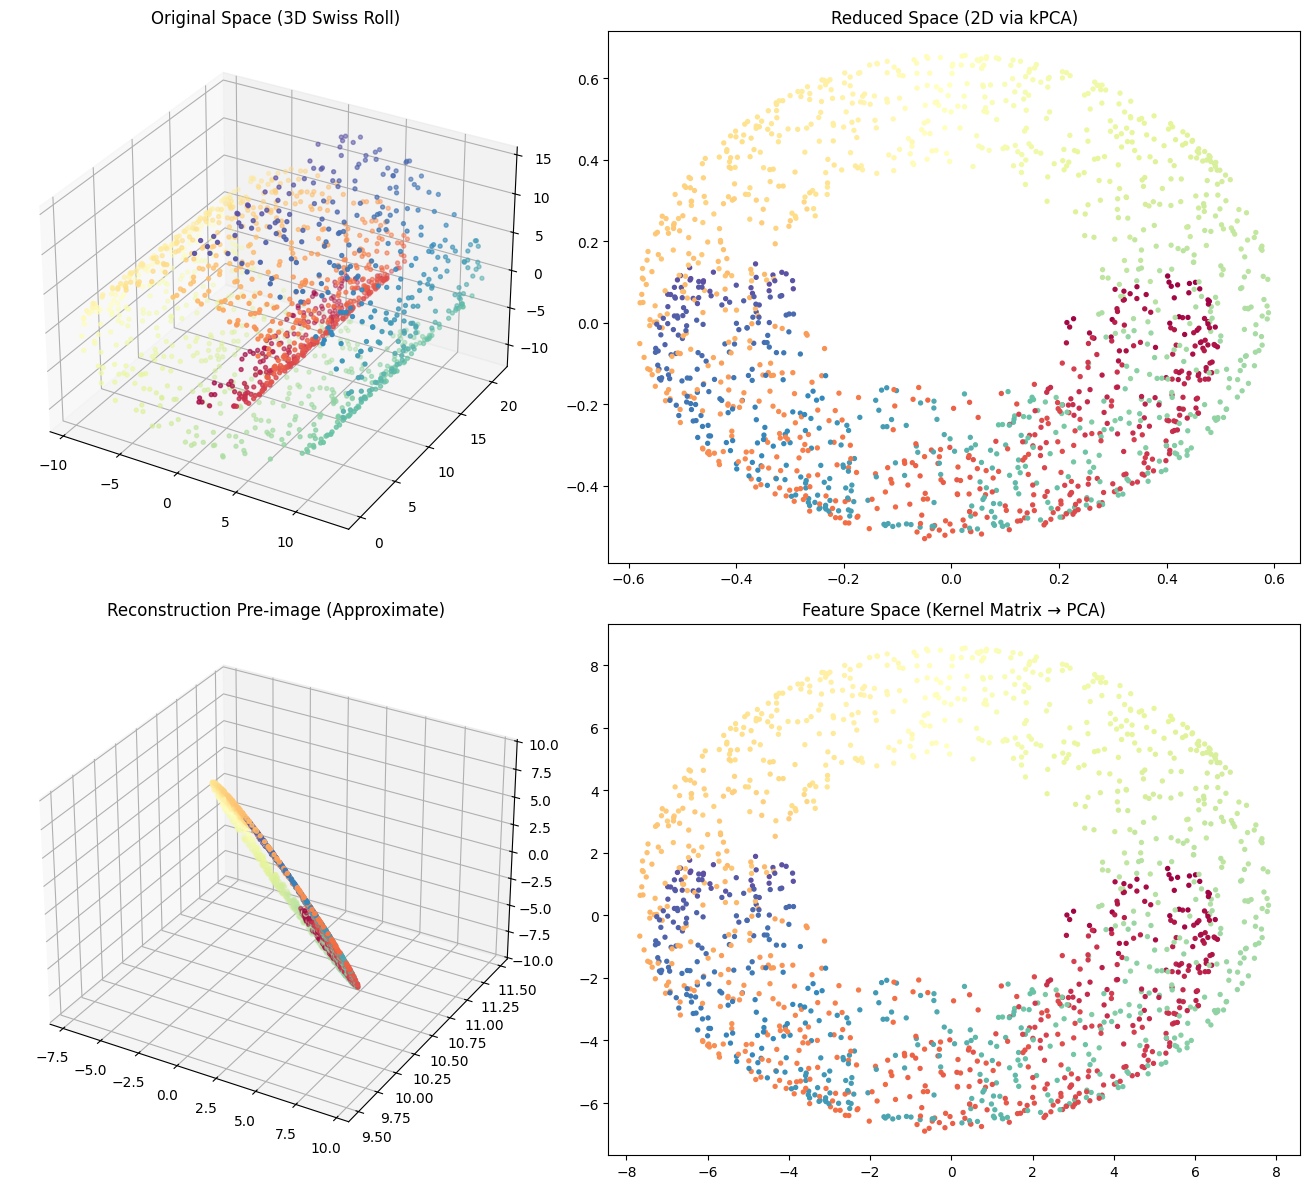

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.decomposition import PCA

# ---------------------------------------------------------
# 1. Generate Swiss Roll dataset
# ---------------------------------------------------------
X, t = make_swiss_roll(n_samples=1500, noise=0.05)
colors = t

# ---------------------------------------------------------
# 2. Kernel PCA (RBF kernel)
# ---------------------------------------------------------
gamma = 0.01
kpca = KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=gamma,
    fit_inverse_transform=True
)
X_kpca = kpca.fit_transform(X)

# ---------------------------------------------------------
# 3. Feature space approximation
#    Use the centered kernel matrix and apply PCA to it
# ---------------------------------------------------------
K = pairwise_kernels(X, metric="rbf", gamma=gamma)

# Center the kernel matrix
N = K.shape[0]
one_n = np.ones((N, N)) / N
K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

# PCA on centered kernel matrix → 2D visualization
feature_pca = PCA(n_components=2)
X_feature = feature_pca.fit_transform(K_centered)

# ---------------------------------------------------------
# 4. Reconstruction (pre-image)
# ---------------------------------------------------------
X_reconstructed = kpca.inverse_transform(X_kpca)

# ---------------------------------------------------------
# 5. Plotting
# ---------------------------------------------------------
fig = plt.figure(figsize=(14, 12))

# --- Original 3D Swiss Roll ---
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, cmap=plt.cm.Spectral, s=8)
ax1.set_title("Original Space (3D Swiss Roll)")

# --- Reduced 2D space ---
ax2 = fig.add_subplot(222)
ax2.scatter(X_kpca[:, 0], X_kpca[:, 1], c=colors, cmap=plt.cm.Spectral, s=8)
ax2.set_title("Reduced Space (2D via kPCA)")

# --- Feature space approximation ---
ax3 = fig.add_subplot(224)
ax3.scatter(X_feature[:, 0], X_feature[:, 1], c=colors, cmap=plt.cm.Spectral, s=8)
ax3.set_title("Feature Space (Kernel Matrix → PCA)")

# --- Reconstruction pre-image ---
ax4 = fig.add_subplot(223, projection='3d')
ax4.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], X_reconstructed[:, 2],
            c=colors, cmap=plt.cm.Spectral, s=8)
ax4.set_title("Reconstruction Pre-image (Approximate)")

plt.tight_layout()
save_fig("KernelPCA_and_reconstruction_pre_image")
plt.show()

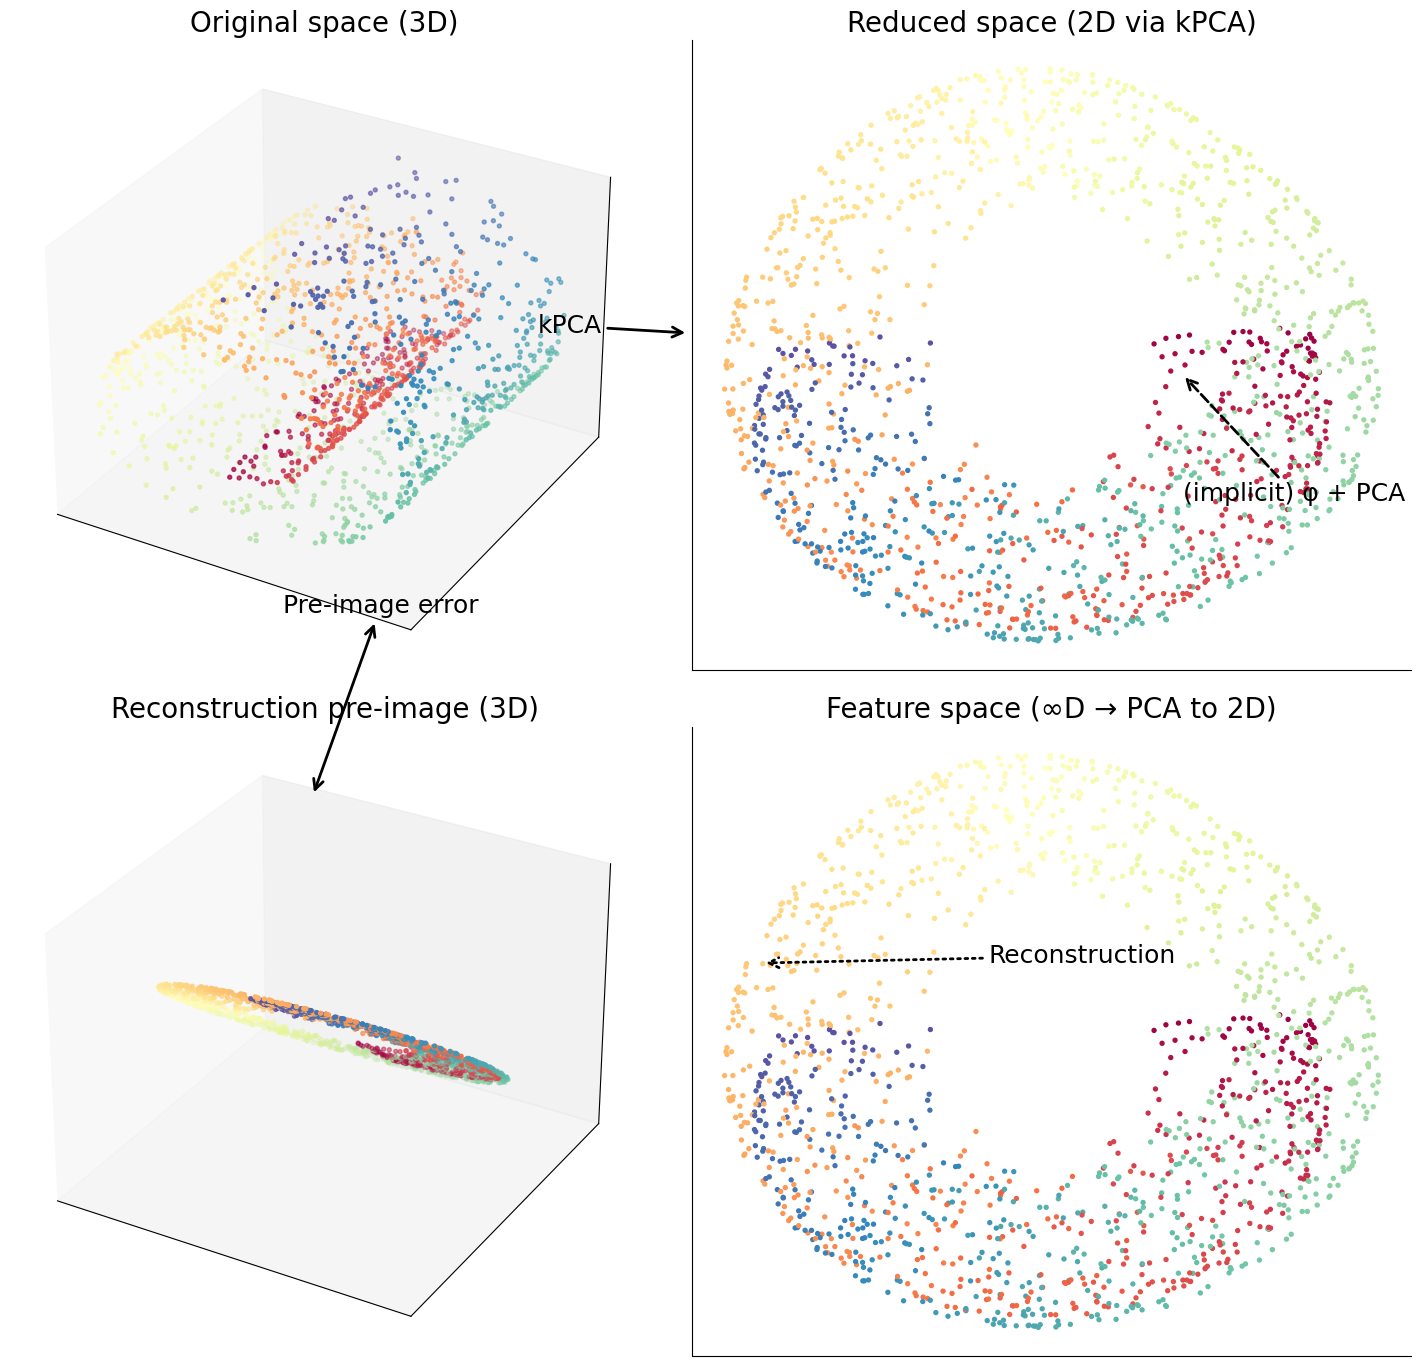

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA, PCA
from sklearn.metrics.pairwise import pairwise_kernels

# ---------------------------------------------------------
# 1. Generate Swiss Roll dataset
# ---------------------------------------------------------
X, t = make_swiss_roll(n_samples=1500, noise=0.05)
colors = t

# ---------------------------------------------------------
# 2. Kernel PCA (RBF kernel)
# ---------------------------------------------------------
gamma = 0.01
kpca = KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=gamma,
    fit_inverse_transform=True
)
X_kpca = kpca.fit_transform(X)

# ---------------------------------------------------------
# 3. Feature space approximation (PCA on centered kernel matrix)
# ---------------------------------------------------------
K = pairwise_kernels(X, metric="rbf", gamma=gamma)

# Center kernel matrix
N = K.shape[0]
one_n = np.ones((N, N)) / N
K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

feature_pca = PCA(n_components=2)
X_feature = feature_pca.fit_transform(K_centered)

# ---------------------------------------------------------
# 4. Reconstruction (pre-image)
# ---------------------------------------------------------
X_reconstructed = kpca.inverse_transform(X_kpca)

# ---------------------------------------------------------
# 5. Plotting
# ---------------------------------------------------------
fig = plt.figure(figsize=(15, 14))

# --- Original 3D Swiss Roll ---
ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, cmap=plt.cm.Spectral, s=8)
ax1.set_title("Original space (3D)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])   # only for 3D axes
# --- Reduced 2D space ---
ax2 = fig.add_subplot(222)
ax2.scatter(X_kpca[:, 0], X_kpca[:, 1], c=colors, cmap=plt.cm.Spectral, s=8)
ax2.set_title("Reduced space (2D via kPCA)")
ax2.set_xticks([])
ax2.set_yticks([])

# --- Reconstruction pre-image ---
ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], X_reconstructed[:, 2],
            c=colors, cmap=plt.cm.Spectral, s=8)
ax3.set_title("Reconstruction pre-image (3D)")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])   # only for 3D axes
# --- Feature space approximation ---
ax4 = fig.add_subplot(224)
ax4.scatter(X_feature[:, 0], X_feature[:, 1], c=colors, cmap=plt.cm.Spectral, s=8)
ax4.set_title("Feature space (∞D → PCA to 2D)")
ax4.set_xticks([])
ax4.set_yticks([])

# ---------------------------------------------------------
# 6. Add arrows + labels AFTER layout
# ---------------------------------------------------------
plt.tight_layout()
fig = plt.gcf()

def arrow1(label, x0, y0, x1, y1, style="-", lw=2):
    plt.annotate(
        label,
        xy=(x1, y1), xytext=(x0, y0),
        xycoords=fig.transFigure, textcoords=fig.transFigure,
        arrowprops=dict(arrowstyle="->", lw=lw, linestyle=style)
    )
def arrow2(label, x0, y0, x1, y1, style="-", lw=2):
    plt.annotate(
        label,
        xy=(x1, y1), xytext=(x0, y0),
        xycoords=fig.transFigure, textcoords=fig.transFigure,
        arrowprops=dict(arrowstyle="<->", lw=lw, linestyle=style)
    )
# Compact arrows positioned close to subplot edges

# Original → Reduced
arrow1("kPCA", 0.40, 0.75, 0.50, 0.75)

# Reduced → Feature space
arrow1("(implicit) φ + PCA", 0.83, 0.63, 0.83, 0.72, style="--")

# Feature space → Reconstruction
arrow1("Reconstruction", 0.70, 0.30, 0.55, 0.30, style=":")

# Reconstruction → Original
arrow2("Pre-image error", 0.23, 0.55, 0.25, 0.42)

plt.show()

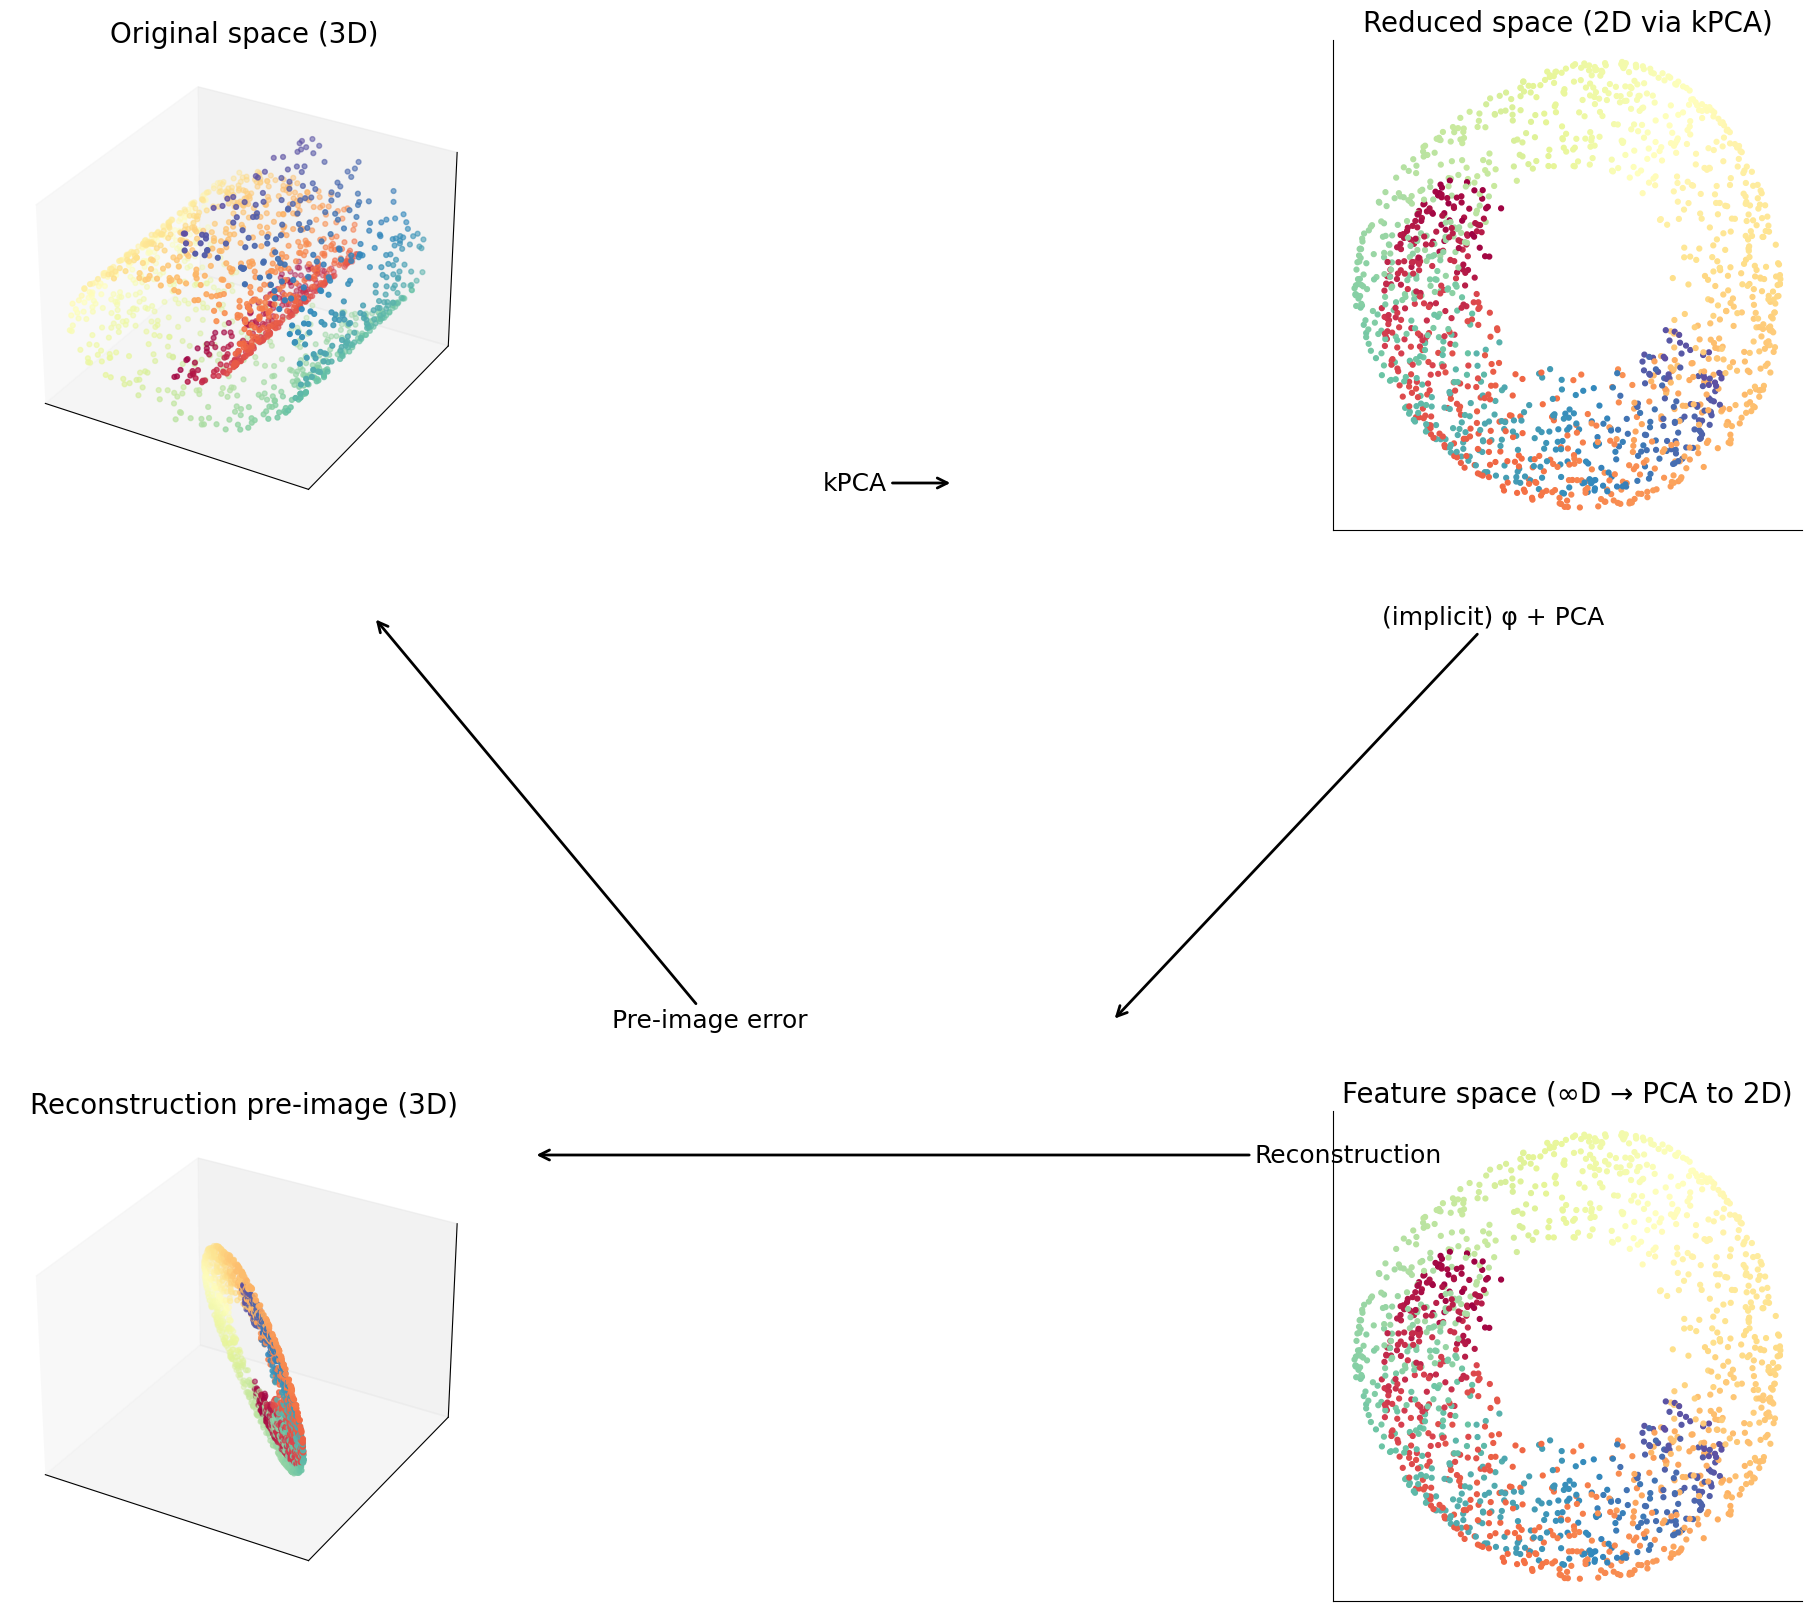

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA, PCA
from sklearn.metrics.pairwise import pairwise_kernels

# ---------------------------------------------------------
# 1. Generate Swiss Roll dataset
# ---------------------------------------------------------
X, t = make_swiss_roll(n_samples=1500, noise=0.05)
colors = t

# ---------------------------------------------------------
# 2. Kernel PCA (RBF kernel)
# ---------------------------------------------------------
gamma = 0.01
kpca = KernelPCA(
    n_components=2,
    kernel="rbf",
    gamma=gamma,
    fit_inverse_transform=True
)
X_kpca = kpca.fit_transform(X)

# ---------------------------------------------------------
# 3. Feature space approximation (PCA on centered kernel matrix)
# ---------------------------------------------------------
K = pairwise_kernels(X, metric="rbf", gamma=gamma)

# Center kernel matrix
N = K.shape[0]
one_n = np.ones((N, N)) / N
K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n

feature_pca = PCA(n_components=2)
X_feature = feature_pca.fit_transform(K_centered)

# ---------------------------------------------------------
# 4. Reconstruction (pre-image)
# ---------------------------------------------------------
X_reconstructed = kpca.inverse_transform(X_kpca)

# ---------------------------------------------------------
# 5. Plotting with improved layout + fonts
# ---------------------------------------------------------
plt.rcParams.update({
    "font.size": 18,
    "axes.titlesize": 20,
    "axes.labelsize": 18
})

fig = plt.figure(figsize=(18, 16), constrained_layout=True)

ax1 = fig.add_subplot(221, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, cmap=plt.cm.Spectral, s=12)
ax1.set_title("Original space (3D)")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])   # only for 3D axes
#ax1.set_axis_off()   # hides the entire axis box
ax2 = fig.add_subplot(222)
ax2.scatter(X_kpca[:, 0], X_kpca[:, 1], c=colors, cmap=plt.cm.Spectral, s=12)
ax2.set_title("Reduced space (2D via kPCA)")
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(223, projection='3d')
ax3.scatter(X_reconstructed[:, 0], X_reconstructed[:, 1], X_reconstructed[:, 2],
            c=colors, cmap=plt.cm.Spectral, s=12)
ax3.set_title("Reconstruction pre-image (3D)")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_zticks([])
ax4 = fig.add_subplot(224)
ax4.scatter(X_feature[:, 0], X_feature[:, 1], c=colors, cmap=plt.cm.Spectral, s=12)
ax4.set_title("Feature space (∞D → PCA to 2D)")
ax4.set_xticks([])
ax4.set_yticks([])
# ---------------------------------------------------------
# 6. Axes-anchored short solid arrows
# ---------------------------------------------------------
def connect_axes(ax_from, ax_to, label, lw=2, fontsize=18):
    """Draw a short, solid arrow between two axes using bounding boxes."""
    fig = ax_from.figure
    fbox = ax_from.get_position()
    tbox = ax_to.get_position()

    # Midpoints of edges
    x0 = fbox.x1
    y0 = (fbox.y0 + fbox.y1) / 2

    x1 = tbox.x0
    y1 = (tbox.y0 + tbox.y1) / 2

    # Shorten arrow by interpolating 20% inward
    shorten = 0.20
    x0s = x0 + (x1 - x0) * shorten
    y0s = y0 + (y1 - y0) * shorten
    x1s = x1 - (x1 - x0) * shorten
    y1s = y1 - (y1 - y0) * shorten

    plt.annotate(
        label,
        xy=(x1s, y1s), xytext=(x0s, y0s),
        xycoords='figure fraction', textcoords='figure fraction',
        arrowprops=dict(arrowstyle="->", lw=lw),
        ha='center', va='center', fontsize=fontsize
    )

# Original → Reduced
connect_axes(ax1, ax2, "kPCA")

# Reduced → Feature space
connect_axes(ax2, ax4, "(implicit) φ + PCA")

# Feature space → Reconstruction
connect_axes(ax4, ax3, "Reconstruction")

# Reconstruction → Original
connect_axes(ax3, ax1, "Pre-image error")

plt.show()

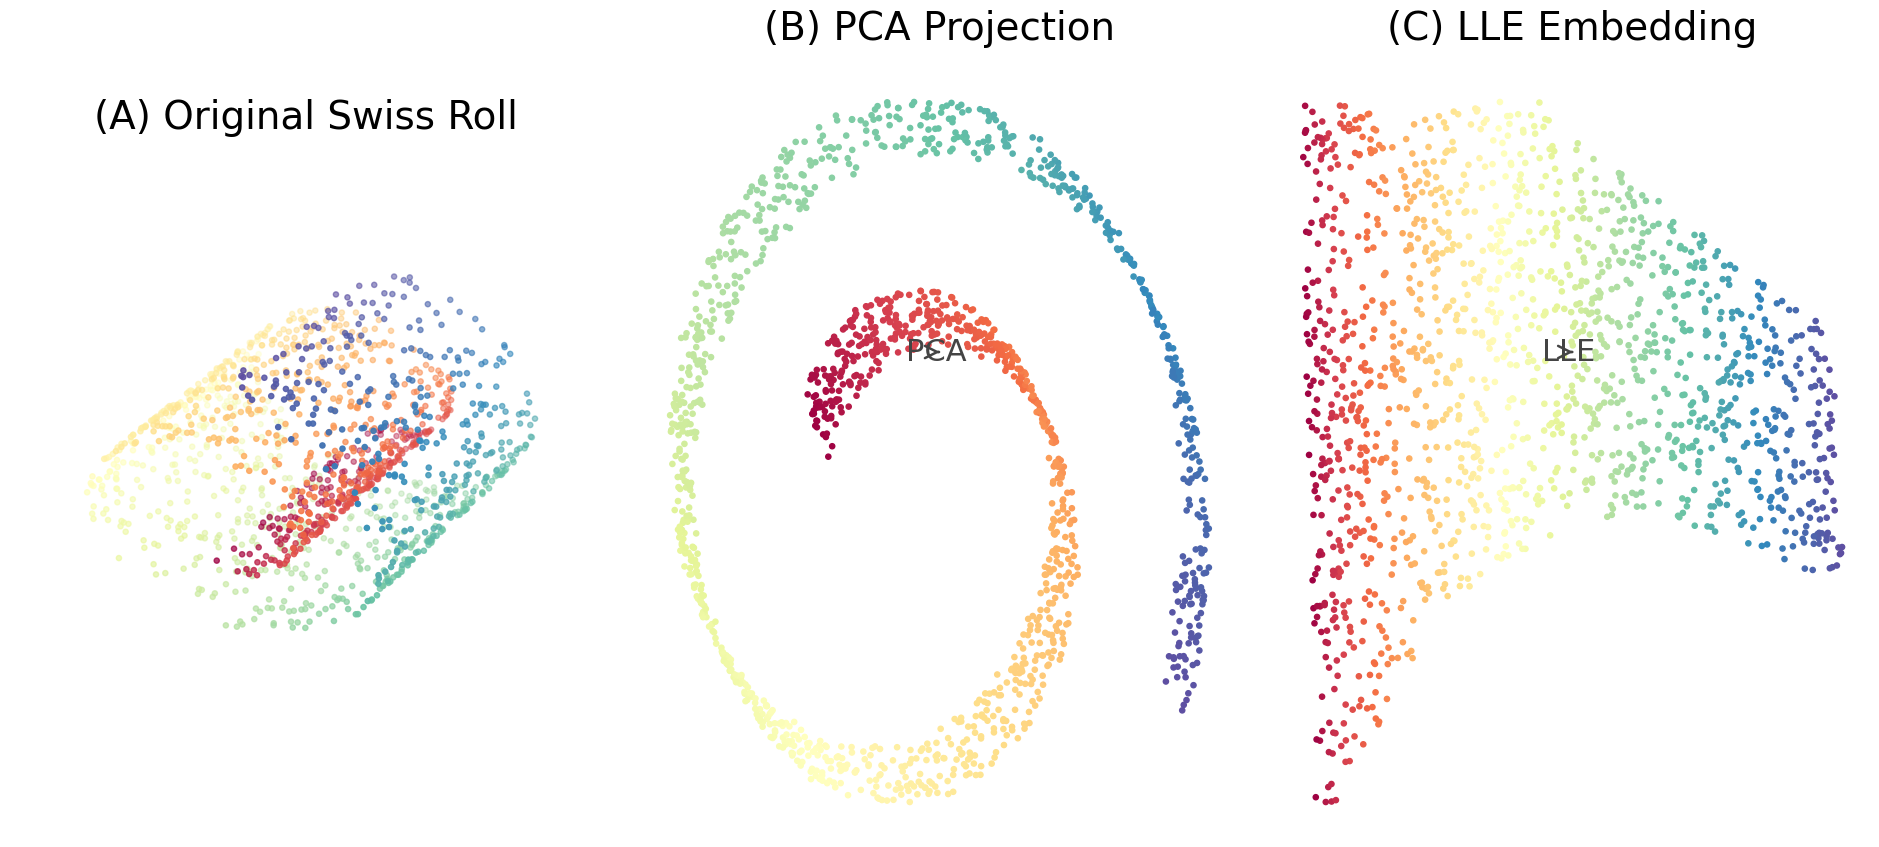

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding

# ---------------------------------------------------------
# 1. Generate Swiss roll dataset
# ---------------------------------------------------------
X, t = make_swiss_roll(n_samples=1500, noise=0.05)
colors = t

# ---------------------------------------------------------
# 2. PCA (baseline)
# ---------------------------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# ---------------------------------------------------------
# 3. LLE embedding
# ---------------------------------------------------------
lle = LocallyLinearEmbedding(
    n_neighbors=12,
    n_components=2,
    method="standard"
)
X_lle = lle.fit_transform(X)

# ---------------------------------------------------------
# 4. Géron-style plot settings
# ---------------------------------------------------------
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 22,
    "axes.titlesize": 28,
    "axes.labelsize": 22,
    "axes.grid": False,
})

fig = plt.figure(figsize=(26, 10))

# ---------------------------------------------------------
# 5. Subplots with manual spacing
# ---------------------------------------------------------

# (A) Original Swiss Roll
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, cmap=plt.cm.Spectral, s=14)
ax1.set_title("(A) Original Swiss Roll", pad=20)
ax1.set_xticks([]); ax1.set_yticks([]); ax1.set_zticks([]); ax1.set_axis_off()

# (B) PCA projection
ax2 = fig.add_subplot(132)
ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap=plt.cm.Spectral, s=14)
ax2.set_title("(B) PCA Projection", pad=20)
ax2.set_xticks([]); ax2.set_yticks([]); ax2.set_axis_off()

# (C) LLE embedding
ax3 = fig.add_subplot(133)
ax3.scatter(X_lle[:, 0], X_lle[:, 1], c=colors, cmap=plt.cm.Spectral, s=14)
ax3.set_title("(C) LLE Embedding", pad=20)
ax3.set_xticks([]); ax3.set_yticks([]); ax3.set_axis_off()

# ---------------------------------------------------------
# 6. Move figure #2 and #3 closer together
# ---------------------------------------------------------
# Get positions
p1 = ax1.get_position()
p2 = ax2.get_position()
p3 = ax3.get_position()

# Shift PCA and LLE panels closer
ax2.set_position([p2.x0 - 0.03, p2.y0, p2.width, p2.height])
ax3.set_position([p3.x0 - 0.06, p3.y0, p3.width, p3.height])

# ---------------------------------------------------------
# 7. Short, thin Géron-style arrows
# ---------------------------------------------------------
def connect_axes(ax_from, ax_to, label, lw=1.8, fontsize=22, shorten=0.45):
    fig = ax_from.figure
    fbox = ax_from.get_position()
    tbox = ax_to.get_position()

    x0 = fbox.x1
    y0 = (fbox.y0 + fbox.y1) / 2
    x1 = tbox.x0
    y1 = (tbox.y0 + tbox.y1) / 2

    x0s = x0 + (x1 - x0) * shorten
    y0s = y0 + (y1 - y0) * shorten
    x1s = x1 - (x1 - x0) * shorten
    y1s = y1 - (y1 - y0) * shorten

    plt.annotate(
        label,
        xy=(x1s, y1s), xytext=(x0s, y0s),
        xycoords='figure fraction', textcoords='figure fraction',
        arrowprops=dict(arrowstyle="->", lw=lw, color="#444444"),
        ha='center', va='center', fontsize=fontsize, color="#444444"
    )

connect_axes(ax1, ax2, "PCA")
connect_axes(ax2, ax3, "LLE")

plt.show()